First of all, I am very keen on trying new methods.
<br>

I have used the following methods.

* I used a model created with <b>ConvMixer </b> blocks [1,2],
* <b>gelu</b> activation function during the feature extraction stage,
* The project took place using <b>Google TPU</b>,
* Used <b>tf.data</b> for input pipeline,


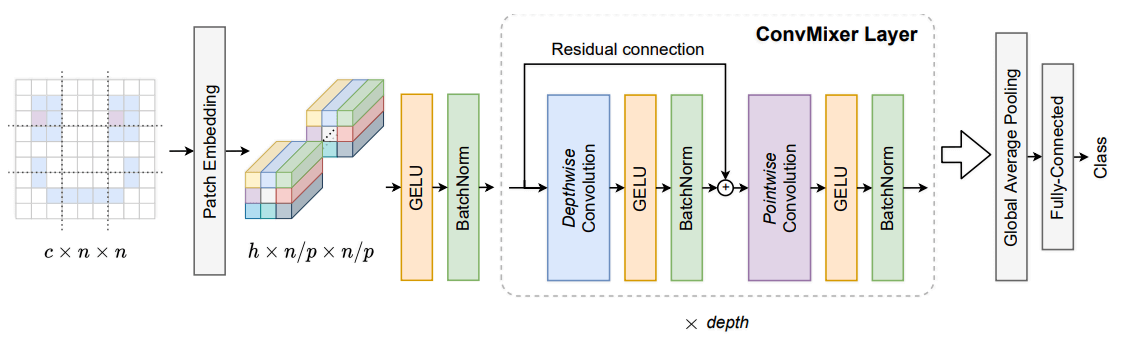

<i> ConvMixer Layer from the paper [1]</i>

## Test Set Predictions
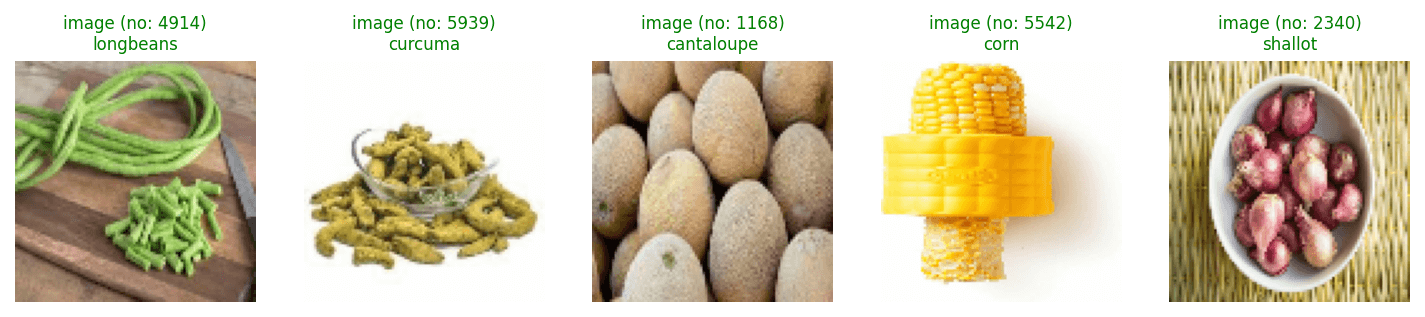
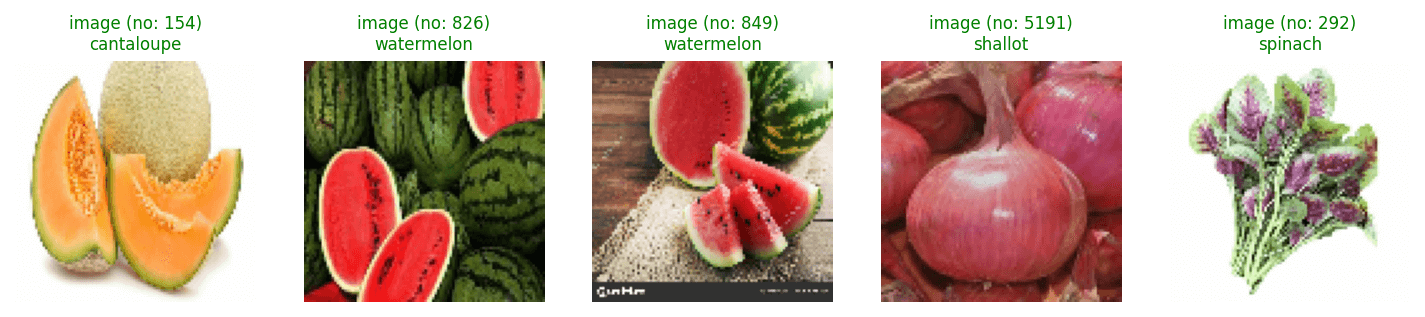


## My Another Projects
* [Skin Cancer Detect w/Meta Learning (CNN, CatBoost)](https://www.kaggle.com/code/banddaniel/skin-cancer-detect-w-meta-learning-cnn-catboost)
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)
* [Jellyfish Detect (10CV Custom ConvMixer) (F1 Score:0.87)](https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87)


## References
1. Trockman, A., & Kolter, J. Z. (2022). Patches Are All You Need? (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2201.09792
2. https://keras.io/examples/vision/convmixer

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback

IMG_SIZE = 96,96
BATCH_SIZE = 256
SEED = 10
AUTO = tf.data.AUTOTUNE

D1028 19:54:57.379706360      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1028 19:54:57.379736293      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1028 19:54:57.379740075      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1028 19:54:57.379743098      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1028 19:54:57.379746021      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1028 19:54:57.379749014      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1028 19:54:57.379751640      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1028 19:54:57.

In [2]:
# Connecting TPU and creating strategy and the model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
stg = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [3]:
# Creating main dataframe contains image paths and their classes.


# look-up table
classes = {0: 'aloevera', 1: 'banana', 2: 'bilimbi', 3: 'cantaloupe', 4: 'cassava', 5: 'coconut', 6: 'corn', 7: 'cucumber', 8: 'curcuma', 9: 'eggplant', 10: 'galangal', 11: 'ginger', 12: 'guava', 13: 'kale', 14: 'longbeans', 15: 'mango', 16: 'melon', 17: 'orange', 18: 'paddy', 19: 'papaya', 20: 'peperchili', 21: 'pineapple', 22: 'pomelo', 23: 'shallot', 24: 'soybeans', 25: 'spinach', 26: 'sweetpotatoes', 27: 'tobacco', 28: 'waterapple', 29: 'watermelon'}


train_data = pd.read_csv('/kaggle/input/plants-classification/train.csv')
valid_data = pd.read_csv('/kaggle/input/plants-classification/val.csv')
test_data = pd.read_csv('/kaggle/input/plants-classification/test.csv')

train_data = shuffle(train_data).reset_index(drop = True)
valid_data = shuffle(valid_data).reset_index(drop = True)
test_data = shuffle(test_data).reset_index(drop = True)

# Creating full image directories
train_data['full_link'] = '/kaggle/input/plants-classification/' + train_data['image:FILE']
valid_data['full_link'] = '/kaggle/input/plants-classification/' + valid_data['image:FILE']
test_data['full_link'] = '/kaggle/input/plants-classification/' + test_data['image:FILE']


print("train images: ", train_data.shape[0])
print("validation images: ", valid_data.shape[0])
print("test images: ", test_data.shape[0])

train images:  21000
validation images:  3000
test images:  6000


In [4]:
train_data.head()

image:FILE  category  \
0      train/pomelo/pomelo211.jpg        22   
1      train/banana/banana164.jpg         1   
2  train/cucumber/cucumber294.jpg         7   
3    train/curcuma/curcuma512.jpg         8   
4    train/coconut/coconut621.jpg         5   

                                           full_link  
0  /kaggle/input/plants-classification/train/pome...  
1  /kaggle/input/plants-classification/train/bana...  
2  /kaggle/input/plants-classification/train/cucu...  
3  /kaggle/input/plants-classification/train/curc...  
4  /kaggle/input/plants-classification/train/coco...

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [5]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Basic data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    
    return img, label

In [6]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['full_link'], train_data['category']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE * 10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['full_link'], valid_data['category']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['full_link'], test_data['category']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

# <span style="color:#e74c3c;"> Creating </span> Custom ConvMixer Layer

In [7]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
      
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

# <span style="color:#e74c3c;"> CNN </span> Model


In [8]:
with stg.scope():
    FEATURES = 256
    inp = Input(shape = (*IMG_SIZE, 3))

    X = Conv2D(FEATURES, 2, 2)(inp)
    X = Activation('gelu')(X)
    X = BatchNormalization()(X)

    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)


    X = GlobalAveragePooling2D()(X)
    out = Dense(30, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top_10_acc", dtype=None) ] )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 256)       3328      
                                                                 
 activation (Activation)     (None, 48, 48, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 256)      1024      
 ormalization)                                                   
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 48, 48, 256)      74496     
 )                                                               
                                                                 
 CONVMIXER_2 (ConvMixerBlock  (None, 48, 48, 256)      74496 

# <span style="color:#e74c3c;"> Training</span> 

In [9]:
hist = model.fit(train_dataset, epochs = 125, batch_size = BATCH_SIZE, validation_data = valid_dataset)

Epoch 1/125


2023-10-28 19:55:27.203763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-28 19:55:27.579466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


83/83 [==============================] - ETA: 0s - loss: 2.8613 - acc: 0.2074 - top_10_acc: 0.7292

2023-10-28 19:56:21.833967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-28 19:56:21.988794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


83/83 [==============================] - 71s 542ms/step - loss: 2.8613 - acc: 0.2074 - top_10_acc: 0.7292 - val_loss: 3.4538 - val_acc: 0.0333 - val_top_10_acc: 0.3333
Epoch 2/125
83/83 [==============================] - 9s 98ms/step - loss: 2.4215 - acc: 0.3150 - top_10_acc: 0.8476 - val_loss: 3.5207 - val_acc: 0.0333 - val_top_10_acc: 0.3283
Epoch 3/125
83/83 [==============================] - 9s 97ms/step - loss: 2.2228 - acc: 0.3689 - top_10_acc: 0.8785 - val_loss: 3.5405 - val_acc: 0.0333 - val_top_10_acc: 0.3300
Epoch 4/125
83/83 [==============================] - 9s 98ms/step - loss: 2.0886 - acc: 0.4048 - top_10_acc: 0.8940 - val_loss: 3.5531 - val_acc: 0.0297 - val_top_10_acc: 0.3337
Epoch 5/125
83/83 [==============================] - 9s 96ms/step - loss: 1.9804 - acc: 0.4364 - top_10_acc: 0.9075 - val_loss: 3.6472 - val_acc: 0.0287 - val_top_10_acc: 0.3487
Epoch 6/125
83/83 [==============================] - 9s 97ms/step - loss: 1.8940 - acc: 0.4610 - top_10_acc: 0.9162 - va

# <span style="color:#e74c3c;"> Training </span> Results

Text(0.5, 1.0, 'top 10 classes accuracy')

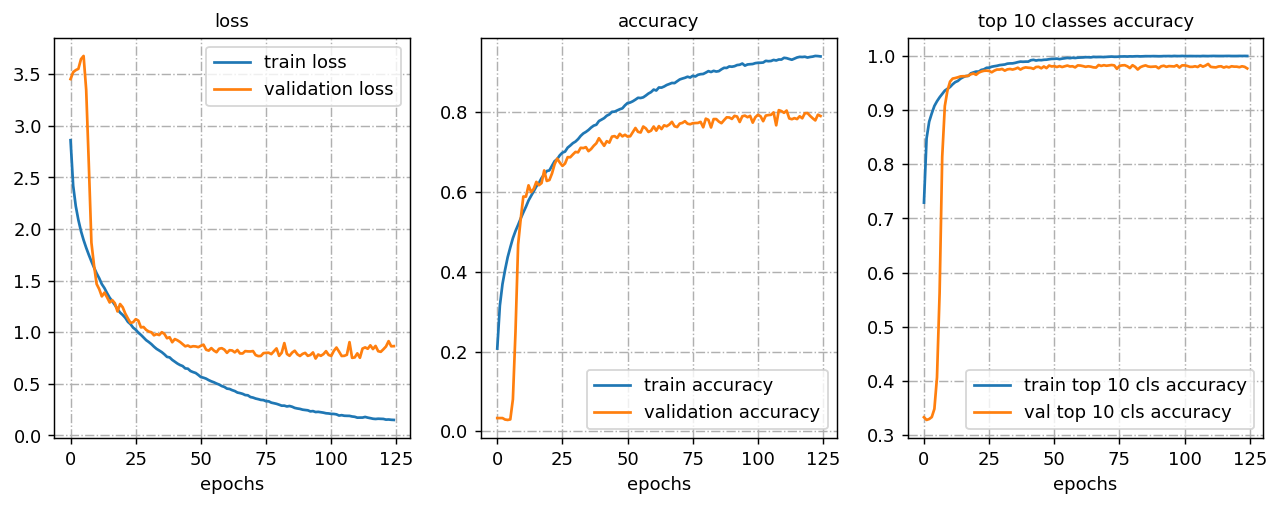

In [10]:
fig, axs = plt.subplots(1,3, figsize = (12, 4), dpi = 130)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].legend(['train loss', 'validation loss'], fontsize = 10)
axs[0].set_title('loss', fontsize = 10)


axs[1].grid(linestyle = 'dashdot')
axs[1].plot(hist.history['acc'])
axs[1].plot(hist.history['val_acc'])
axs[1].set_xlabel('epochs', fontsize = 10)
axs[1].legend(['train accuracy', 'validation accuracy'], fontsize = 10)
axs[1].set_title('accuracy', fontsize = 10)

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(hist.history['top_10_acc'])
axs[2].plot(hist.history['val_top_10_acc'])
axs[2].set_xlabel('epochs', fontsize = 10)
axs[2].legend(['train top 10 cls accuracy', 'val top 10 cls accuracy'], fontsize = 10)
axs[2].set_title('top 10 classes accuracy', fontsize = 10)

# <span style="color:#e74c3c;"> Test and Validation </span> Evaluation

In [11]:
with stg.scope():
    val_eval_final = model.evaluate(valid_dataset)
    print('Validation Loss: {0:.3f}'.format(val_eval_final[0]))
    print('Validation Accuracy: {0:.2f} %'.format(val_eval_final[1]*100))
    print('Validation Top 10 Classes Accuracy: {0:.2f} %'.format(val_eval_final[2]*100))
    print('--'*50)
    test_eval_final = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_final[0]))
    print('Test Accuracy: {0:.2f} %'.format(test_eval_final[1]*100))
    print('Test Top 10 Classes Accuracy: {0:.2f} %'.format(test_eval_final[2]*100))

12/12 [==============================] - 1s 34ms/step - loss: 0.8656 - acc: 0.7900 - top_10_acc: 0.9767
Validation Loss: 0.866
Validation Accuracy: 79.00 %
Validation Top 10 Classes Accuracy: 97.67 %
----------------------------------------------------------------------------------------------------
24/24 [==============================] - 4s 133ms/step - loss: 0.9520 - acc: 0.7778 - top_10_acc: 0.9788
Test Loss: 0.952
Test Accuracy: 77.78 %
Test Top 10 Classes Accuracy: 97.88 %


In [12]:
# Test set prediction

test_take_sample =  test_dataset.take(-1)
test_take_ = list(test_take_sample)
pred = model.predict(test_take_sample)
pred = np.argmax(pred, axis = 1)

2023-10-28 20:15:54.843552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-28 20:15:54.979554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


24/24 [==============================] - 7s 112ms/step


# <span style="color:#e74c3c;">Test Classification </span> Report

In [13]:
clf = classification_report(test_data['category'] , pred, target_names = list(classes.values()))
print(clf)

               precision    recall  f1-score   support

     aloevera       0.83      0.77      0.80       200
       banana       0.80      0.51      0.62       200
      bilimbi       0.75      0.93      0.83       200
   cantaloupe       0.44      0.53      0.48       200
      cassava       0.57      0.77      0.66       200
      coconut       0.88      0.42      0.57       200
         corn       0.87      0.85      0.86       200
     cucumber       0.84      0.94      0.88       200
      curcuma       0.86      0.80      0.83       200
     eggplant       0.83      0.81      0.82       200
     galangal       0.70      0.92      0.79       200
       ginger       0.80      0.71      0.75       200
        guava       0.83      0.78      0.81       200
         kale       0.82      0.84      0.83       200
    longbeans       0.87      0.91      0.89       200
        mango       0.69      0.58      0.63       200
        melon       0.46      0.36      0.40       200
       or

# <span style="color:#e74c3c;">Test Confusion </span> Matrix

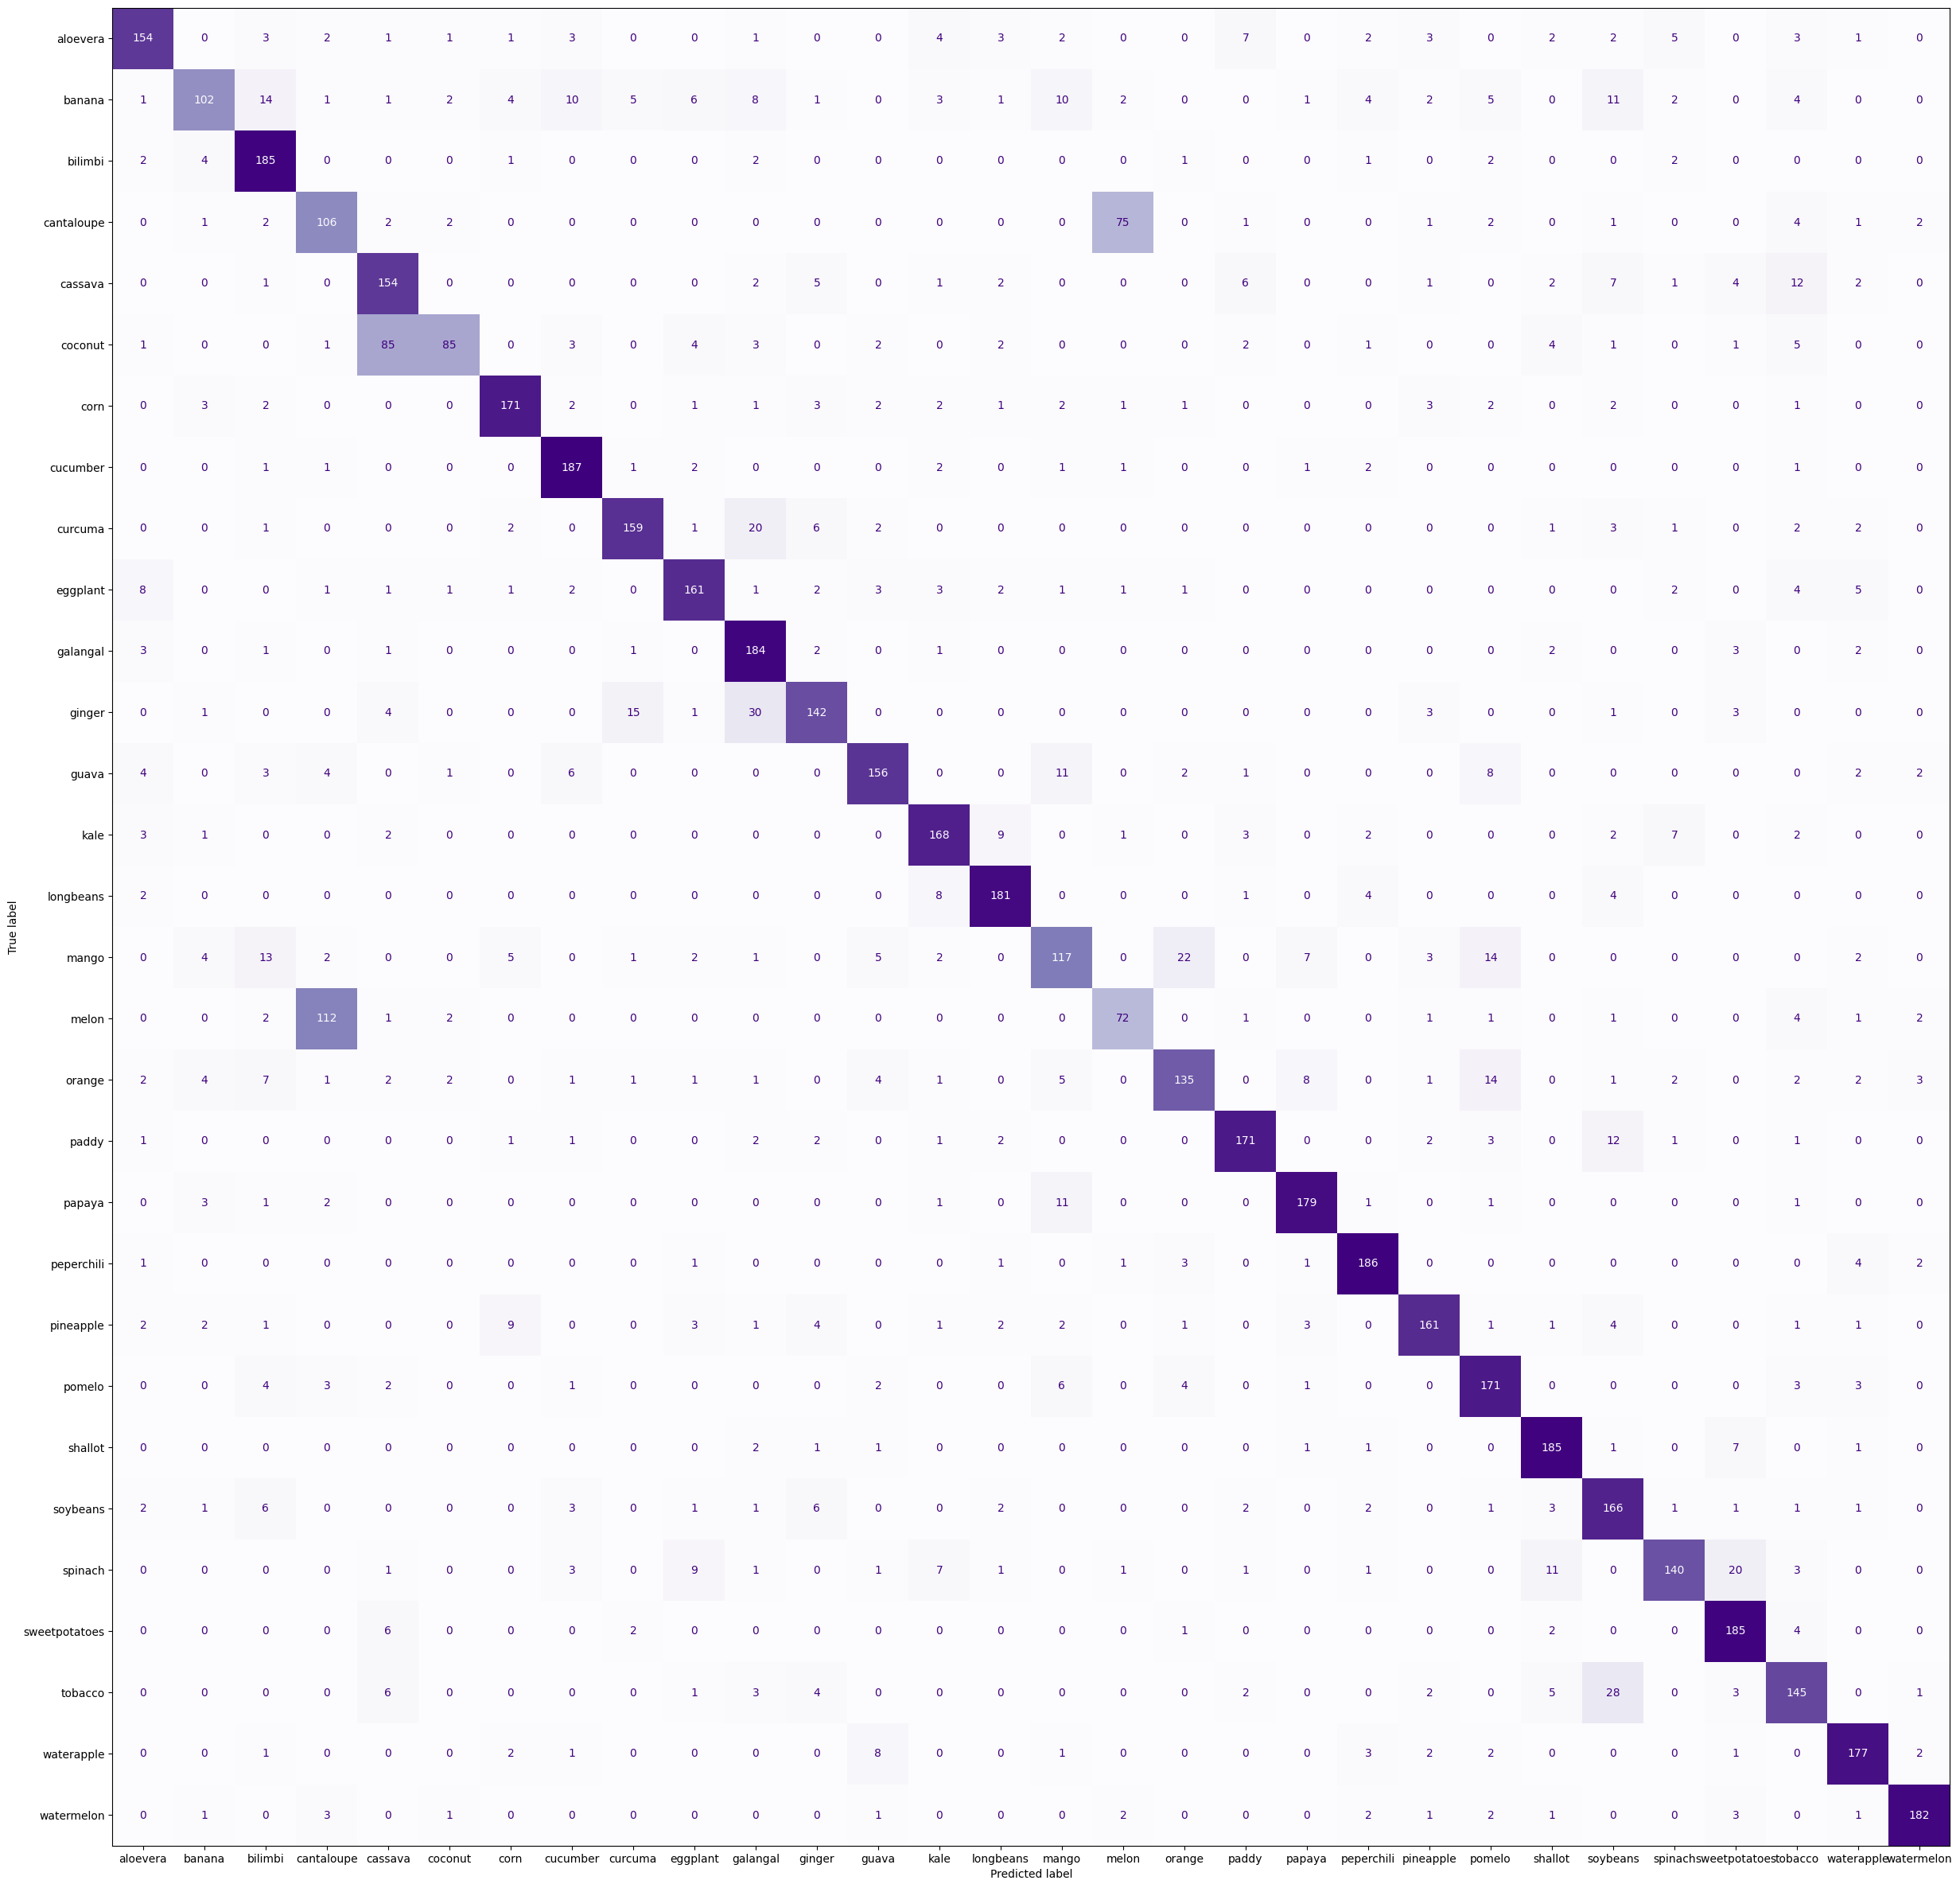

In [14]:
cm = confusion_matrix(test_data['category'] , pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(30, 30))
cmd.plot(ax=ax,  cmap = 'Purples', colorbar = False)

# <span style="color:#e74c3c;"> Test Set</span> Predictions

In [15]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take_[batch_idx[i]][0][image_idx[i]]
        label = test_take_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img) 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

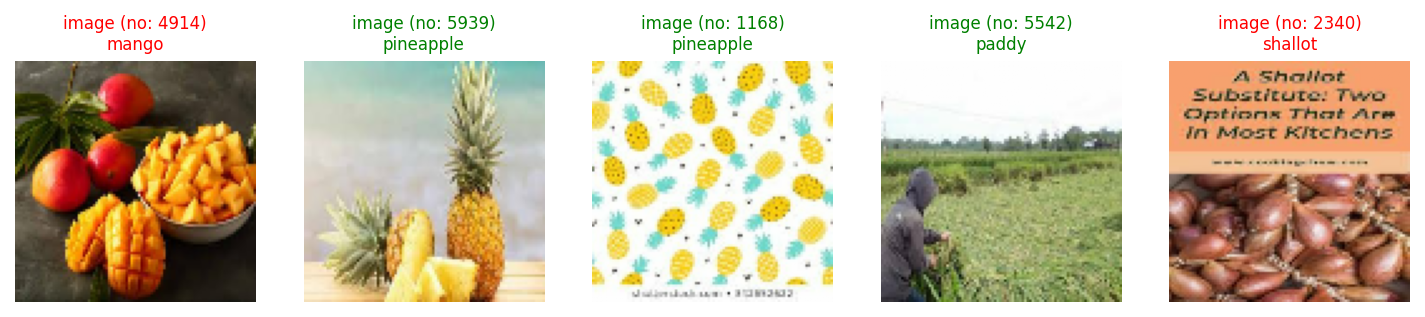

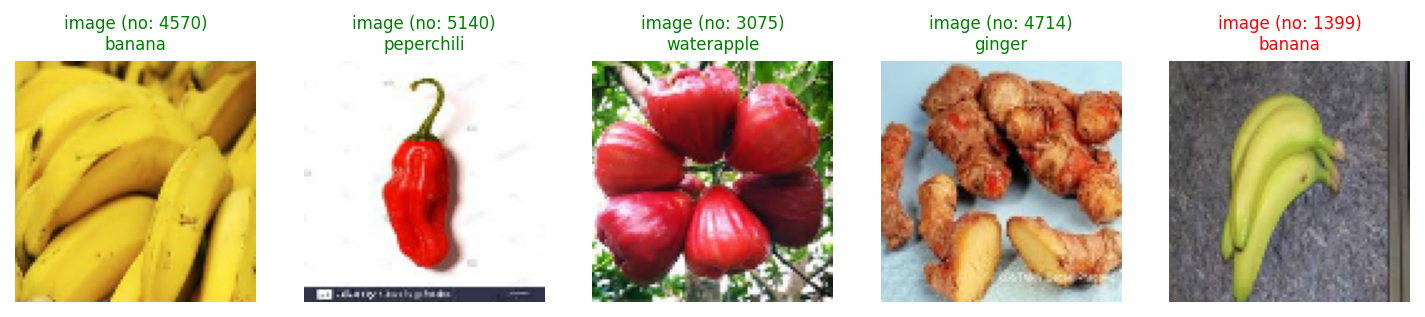

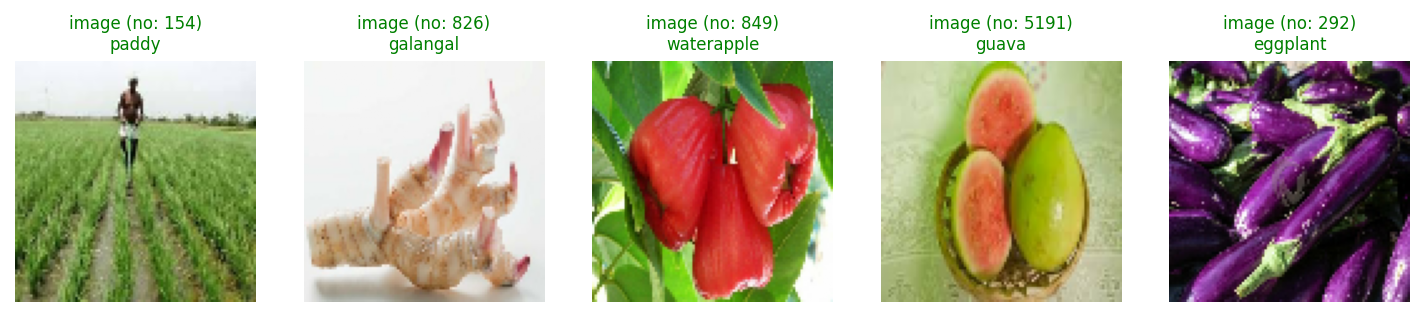

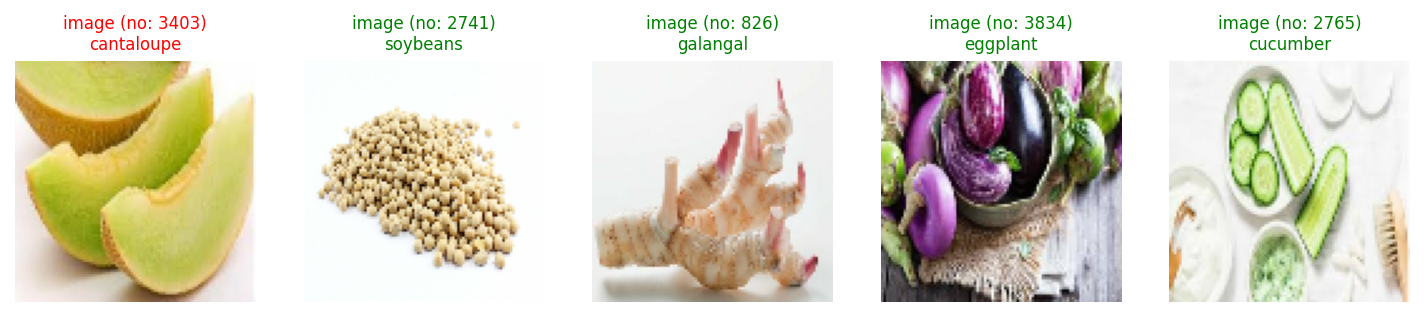

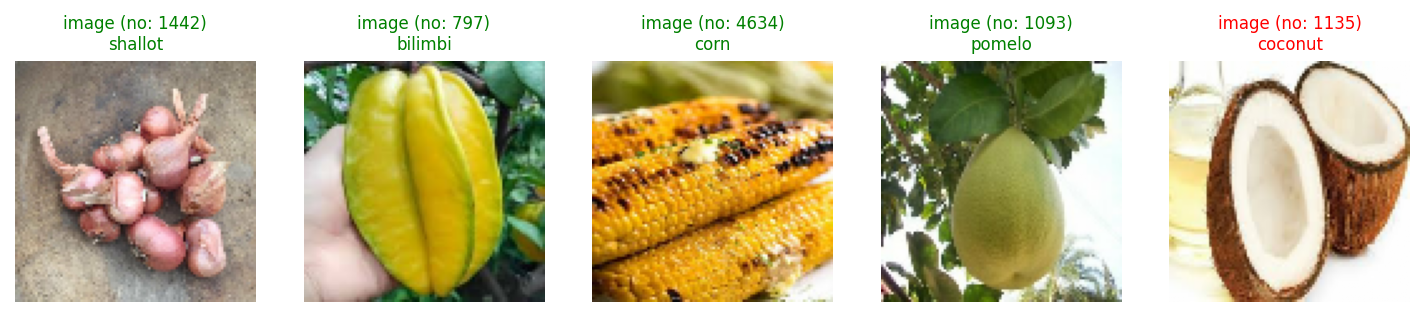

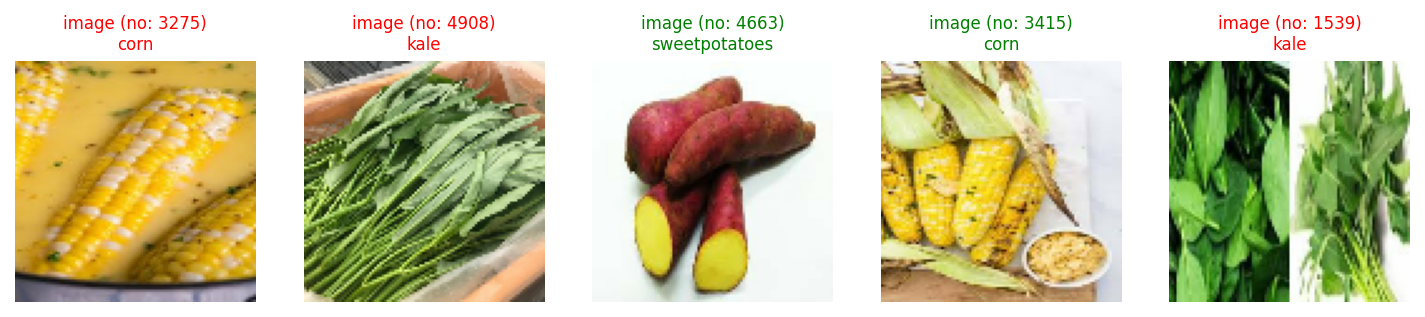

In [16]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 4)
random_test_sample_with_prediction(SEED = 204)
random_test_sample_with_prediction(SEED = 357)
random_test_sample_with_prediction(SEED = 99)
random_test_sample_with_prediction(SEED = 284)
random_test_sample_with_prediction(SEED = 14)